In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
files = ['./input/test_identity.csv', 
         './input/test_transaction.csv',
         './input/train_identity.csv',
         './input/train_transaction.csv',
         './input/sample_submission.csv']

In [3]:
train_tr = pd.read_csv('train_transaction.csv')

In [4]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_tr = pd.read_csv('test_transaction.csv')

In [6]:
test_tr.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_id = pd.read_csv('train_identity.csv')
test_id = pd.read_csv('test_identity.csv')

In [8]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [9]:
test_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [10]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

14

In [11]:
# 의미없는 변수 제거
# vaule가 1개인 변수, 결측치의 비중이 90% 이상인 변수, 90%이상의 값이 동일한 변수 제거

In [12]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [13]:
cols_to_drop

['V113',
 'V122',
 'V105',
 'V118',
 'V301',
 'V77',
 'id_21',
 'id_23',
 'V299',
 'V119',
 'V318',
 'V281',
 'V321',
 'id_18',
 'V68',
 'V108',
 'V305',
 'V55',
 'V86',
 'V295',
 'V296',
 'V293',
 'V137',
 'V133',
 'V298',
 'V66',
 'V115',
 'id_07',
 'V14',
 'V117',
 'V102',
 'V136',
 'V311',
 'id_26',
 'V286',
 'V134',
 'V125',
 'V320',
 'V27',
 'V111',
 'V123',
 'V107',
 'V316',
 'id_27',
 'V121',
 'V101',
 'V297',
 'id_22',
 'V110',
 'V290',
 'V23',
 'V26',
 'V319',
 'V106',
 'V28',
 'V284',
 'V309',
 'V120',
 'V25',
 'dist2',
 'V98',
 'V132',
 'V300',
 'V67',
 'V112',
 'V109',
 'V114',
 'V135',
 'id_24',
 'C3',
 'V24',
 'V88',
 'V104',
 'id_08',
 'V124',
 'V65',
 'V103',
 'V89',
 'D7',
 'id_25',
 'V129',
 'V116']

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 352 entries, TransactionID to DeviceInfo
dtypes: float64(319), int64(4), object(29)
memory usage: 1.6+ GB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 351 entries, TransactionID to DeviceInfo
dtypes: float64(319), int64(3), object(29)
memory usage: 1.3+ GB


In [17]:
train_cate_cols = []
test_cate_cols = []

for i in train.columns:    
    
    if train[i].dtype == 'object':
        train_cate_cols.append(i)
        
    else:
        pass
    
print("train category cols", train_cate_cols)


for i in test.columns:    
    
    if test[i].dtype == 'object':
        test_cate_cols.append(i)
        
    else:
        pass
    
print("test category cols", test_cate_cols)



train category cols ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
test category cols ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [18]:
for col in tqdm_notebook(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

HBox(children=(IntProgress(value=0, max=352), HTML(value='')))

In [19]:
%%time
train = reduce_mem_usage(train)

Mem. usage decreased to 426.33 Mb (73.2% reduction)
Wall time: 2min 32s


In [83]:
#train.to_csv("train_eda_1.csv")
#train = pd.read_csv("train_eda_1.csv")
#train.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [20]:
train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4                  0
card5               4259
card6                  0
addr1              65706
addr2              65706
dist1             352271
P_emaildomain          0
R_emaildomain          0
C1                     0
C2                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
                   ...  
id_01             446307
id_02             449668
id_03             524216
id_04             524216
id_05             453675
id_06             453675
id_09             515614
id_10             515614
id_11             449562


In [21]:
# RFECV does not support NaNs
train.fillna(-999, inplace=True)

In [22]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [23]:
del train

In [24]:
X.shape, y.shape

((590540, 349), (590540,))

In [25]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
1,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
2,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
3,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,136,-999.0,461,4,2,2,2,2,2,2740
4,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565


In [26]:
y.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [27]:
from sklearn.feature_selection import RFECV

In [28]:
clf = lgb.LGBMClassifier()
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [29]:
%%time
rfe.fit(X, y)

Fitting estimator with 349 features.
Fitting estimator with 339 features.
Fitting estimator with 329 features.
Fitting estimator with 319 features.
Fitting estimator with 309 features.
Fitting estimator with 299 features.
Fitting estimator with 289 features.
Fitting estimator with 279 features.
Fitting estimator with 269 features.
Fitting estimator with 259 features.
Fitting estimator with 249 features.
Fitting estimator with 239 features.
Fitting estimator with 229 features.
Fitting estimator with 219 features.
Fitting estimator with 209 features.
Fitting estimator with 199 features.
Fitting estimator with 189 features.
Fitting estimator with 179 features.
Fitting estimator with 169 features.
Fitting estimator with 159 features.
Fitting estimator with 149 features.
Fitting estimator with 139 features.
Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.
Fitting estimator with 99 features.
Fitting estimator with 89 features.
Fit

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=10,
      verbose=2)

In [30]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 159


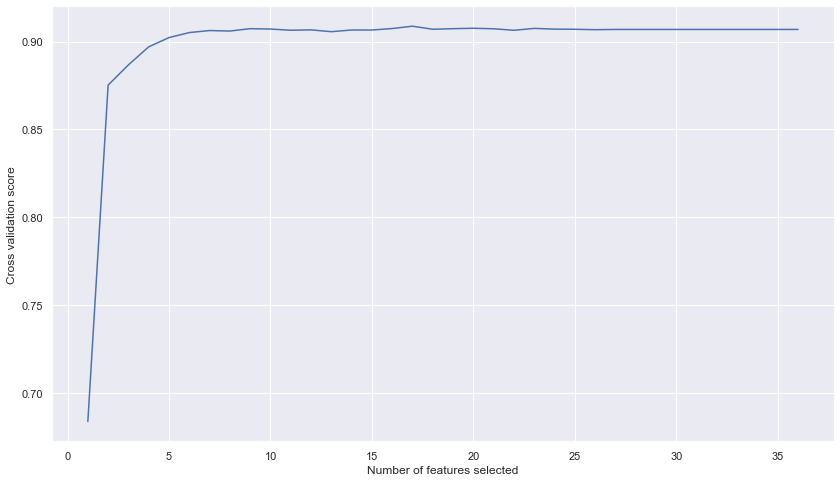

In [31]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [35]:
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  3,
        1,  1,  1,  1,  1,  1, 14,  1,  1,  1,  1,  1,  5, 15,  1,  8,  1,
        4,  7,  1,  1, 17, 17, 17, 17,  3,  1,  1, 17, 15, 15, 15,  1,  1,
       12, 12,  1,  1, 18, 18,  1,  1,  1,  2,  1,  1, 20,  7, 20, 20,  9,
        1,  1,  8,  7,  1,  1, 16, 16,  4,  1,  1,  1, 16,  9,  5,  8,  1,
        1, 19,  1,  3,  1, 19,  3, 19,  1,  1,  1,  1,  3, 19,  1,  1,  1,
       12,  6,  1,  1,  1, 10,  9,  1,  3,  1, 11,  1,  9,  1,  4,  1,  1,
        1,  7,  1,  4,  6, 15,  1, 11,  5, 11, 10, 18,  1,  7, 10,  1, 12,
       10, 15,  2, 17, 20,  8,  1, 10,  1, 18,  1,  1, 18, 10, 13,  1,  1,
       13,  2,  8, 20,  4, 20, 18, 13, 13,  7, 12,  1,  4,  5, 14, 12,  1,
        1,  2, 12, 17, 17, 14, 14, 14, 14,  1,  2, 12,  2,  1, 12,  7, 10,
        1,  1,  8,  5,  1,  1, 11,  6, 16, 16,  4, 20,  2, 20,  1,  1,  9,
       16,  6, 18,  9,  6

In [36]:
X.columns[rfe.ranking_==1]

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=159)

In [37]:
selected_feature = X.columns[rfe.ranking_==1]

In [40]:
for i in selected_feature:
    print(i)

TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D8
D10
D11
D12
D13
D14
D15
M2
M3
M4
M5
M6
M9
V2
V5
V6
V12
V13
V19
V20
V29
V30
V33
V34
V35
V37
V38
V44
V45
V48
V49
V53
V54
V56
V61
V62
V64
V70
V74
V75
V76
V78
V81
V82
V83
V87
V90
V91
V94
V96
V99
V126
V128
V130
V131
V139
V143
V149
V152
V160
V162
V164
V165
V169
V170
V182
V187
V188
V197
V201
V205
V206
V209
V210
V219
V220
V234
V245
V251
V256
V257
V258
V261
V266
V267
V271
V272
V277
V278
V279
V280
V282
V283
V285
V288
V289
V291
V292
V294
V307
V308
V310
V312
V313
V314
V315
V317
V323
V326
V332
V338
id_01
id_02
id_03
id_05
id_06
id_09
id_13
id_14
id_17
id_19
id_20
id_30
id_31
id_32
id_33
id_38
DeviceType
DeviceInfo


In [41]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [42]:
len(useful_features)

279

In [49]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [50]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999917	valid_1's auc: 0.90197
Early stopping, best iteration is:
[749]	training's auc: 0.999419	valid_1's auc: 0.902395
Fold 1 finished in 0:02:10.059254
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999532	valid_1's auc: 0.921143
Early stopping, best iteration is:
[810]	training's auc: 0.998757	valid_1's auc: 0.921769
Fold 2 finished in 0:04:48.496638
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.997873	valid_1's auc: 0.913308
Early stopping, best iteration is:
[921]	training's auc: 0.99723	valid_1's auc: 0.91358
Fold 3 finished in 0:08:04.860614
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.994917	valid_1's auc: 0.933881
Early stopping, best iteration is:
[1189]	training's auc: 0.996773	valid_1's au

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 349 entries, TransactionAmt to DeviceInfo
dtypes: float16(285), float32(34), int16(4), int8(26)
memory usage: 421.3 MB


In [45]:
X.shape, y.shape

((590540, 349), (590540,))

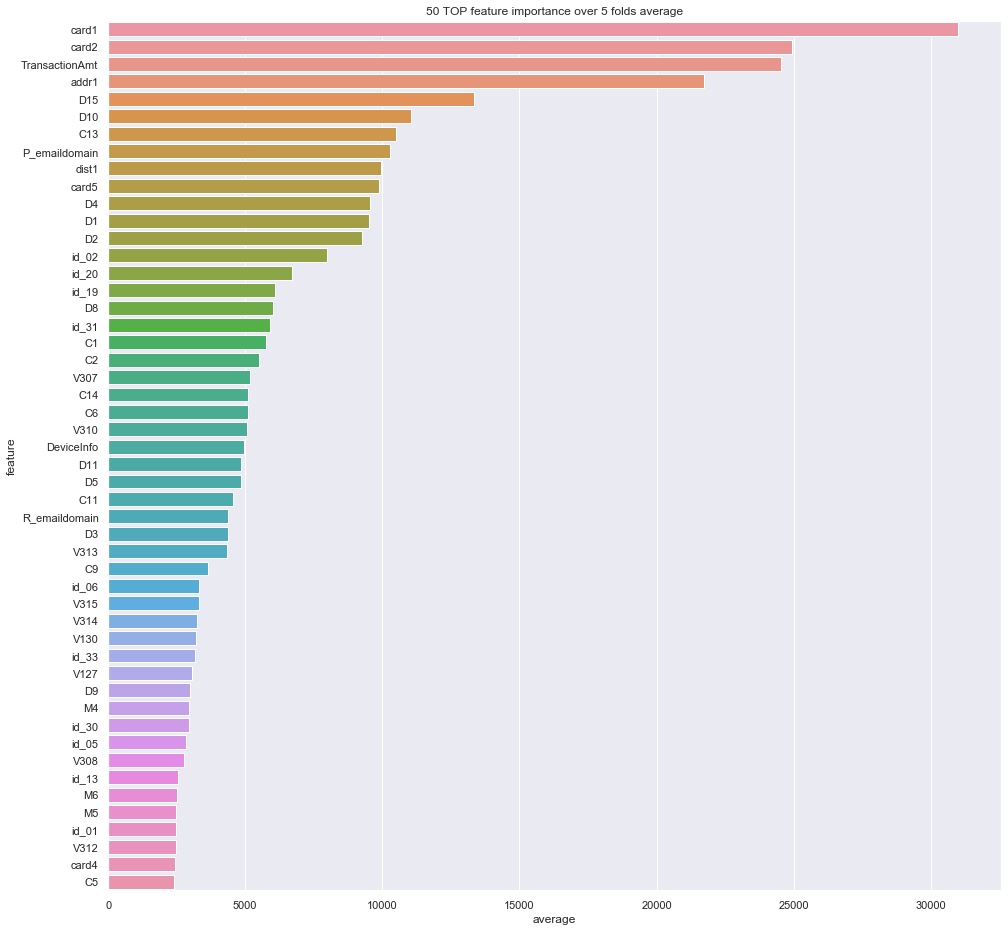

In [51]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [52]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

In [ ]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

In [ ]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]